In [1]:
import pandas as pd
import numpy as np

import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import torch.utils.data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
train_file = "./kaggle/brist1d/train.csv"
test_file = "./kaggle/brist1d/test.csv"

df = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

print("Num features train", df.shape[1])
print("Num features test", df_test.shape[1])

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        df_test[col] = df_test[col].astype('category')

df.dtypes

/tmp/ipykernel_61077/2519436331.py:4: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(train_file)


Num features train 508
Num features test 507


id               category
p_num            category
time             category
bg-5:55           float64
bg-5:50           float64
                   ...   
activity-0:15    category
activity-0:10    category
activity-0:05    category
activity-0:00    category
bg+1:00           float64
Length: 508, dtype: object

## Data Cleaning - handling missing values

In [3]:
features = df.columns
bg_cols = [col for col in features if "bg" in col]
insulin_cols = [col for col in features if "insulin" in col]
carbs_cols = [col for col in features if "carbs" in col]
hr_cols = [col for col in features if "hr" in col]
steps_cols = [col for col in features if "steps" in col]
cals_cols = [col for col in features if "cals" in col]
activity_cols = [col for col in features if "activity" in col]

Fill missing values for features based on:
- mean value: blood glucose, carbs, cals
- zeroes: insulin
- forward filled (i.e. propagates the last observation forward): heart rate, steps

In [4]:
for feature in [*bg_cols, *carbs_cols, *cals_cols]:
    if feature != "bg+1:00":
        df[feature] = df[feature].fillna(df[feature].mean())
        df_test[feature] = df_test[feature].fillna(df_test[feature].mean())

for feature in insulin_cols:
    df[feature] = df[feature].fillna(0)
    df_test[feature] = df_test[feature].fillna(0)

for feature in [*hr_cols, *steps_cols]:
    df[feature] = df[feature].fillna(method="ffill")
    df_test[feature] = df_test[feature].fillna(method="ffill")

    df[feature] = df[feature].fillna(method="bfill")
    df_test[feature] = df_test[feature].fillna(method="bfill")

print("NaNs in training data: ", df.isna().sum())
print("NaNs in testing data", df_test.isna().sum())

print("Num features train", df.shape[1])
print("Num features test", df_test.shape[1])

NaNs in training data:  id                    0
p_num                 0
time                  0
bg-5:55               0
bg-5:50               0
                  ...  
activity-0:15    174293
activity-0:10    174287
activity-0:05    174271
activity-0:00    174287
bg+1:00               0
Length: 508, dtype: int64
NaNs in testing data id                  0
p_num               0
time                0
bg-5:55             0
bg-5:50             0
                 ... 
activity-0:20    3580
activity-0:15    3587
activity-0:10    3586
activity-0:05    3581
activity-0:00    3583
Length: 507, dtype: int64
Num features train 508
Num features test 507


In [5]:
df['time'] = pd.to_timedelta(df['time']).dt.total_seconds()
df_test['time'] = pd.to_timedelta(df_test['time']).dt.total_seconds()

# for now we just ignore participant profiles
df.drop(columns=["p_num", "id", *activity_cols], inplace=True)
test_ids = df_test["id"]
df_test.drop(columns=["p_num", "id", *activity_cols], inplace=True)

# drop remaining NAs that could not be filled in
# df = df.dropna(how="any")
# df_test = df_test.dropna(how="any")

y = df["bg+1:00"]
df = df.drop("bg+1:00", axis=1)

print("Num features train", df.shape[1])
print("Num features test", df_test.shape[1])

Num features train 433
Num features test 433


In [6]:
print("Data train shape", df.shape)
print("Data test shape", df_test.shape)

Data train shape (177024, 433)
Data test shape (3644, 433)


### Normalize features

In [7]:
# scale features
scaler = StandardScaler()
df = scaler.fit_transform(df)
df_test = scaler.fit_transform(df_test)
y = scaler.fit_transform(np.reshape(y.values, (-1, 1)))

# transform to tensor and reshape
df_tensor = torch.Tensor(df)
df_test_tensor = torch.Tensor(df_test)
y_tensor = torch.Tensor(y)
print(df_tensor.shape)
print(y_tensor.shape)

# create dataloader
dataset = torch.utils.data.TensorDataset(df_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)


torch.Size([177024, 433])
torch.Size([177024, 1])


#### Checking the data before feeding it into the network

In [8]:
print(df_tensor.isnan().any())

for col in range(df_tensor.shape[1]):
    print("Col", col, df_tensor[:, col].isnan().sum())

tensor(False)
Col 0 tensor(0)
Col 1 tensor(0)
Col 2 tensor(0)
Col 3 tensor(0)
Col 4 tensor(0)
Col 5 tensor(0)
Col 6 tensor(0)
Col 7 tensor(0)
Col 8 tensor(0)
Col 9 tensor(0)
Col 10 tensor(0)
Col 11 tensor(0)
Col 12 tensor(0)
Col 13 tensor(0)
Col 14 tensor(0)
Col 15 tensor(0)
Col 16 tensor(0)
Col 17 tensor(0)
Col 18 tensor(0)
Col 19 tensor(0)
Col 20 tensor(0)
Col 21 tensor(0)
Col 22 tensor(0)
Col 23 tensor(0)
Col 24 tensor(0)
Col 25 tensor(0)
Col 26 tensor(0)
Col 27 tensor(0)
Col 28 tensor(0)
Col 29 tensor(0)
Col 30 tensor(0)
Col 31 tensor(0)
Col 32 tensor(0)
Col 33 tensor(0)
Col 34 tensor(0)
Col 35 tensor(0)
Col 36 tensor(0)
Col 37 tensor(0)
Col 38 tensor(0)
Col 39 tensor(0)
Col 40 tensor(0)
Col 41 tensor(0)
Col 42 tensor(0)
Col 43 tensor(0)
Col 44 tensor(0)
Col 45 tensor(0)
Col 46 tensor(0)
Col 47 tensor(0)
Col 48 tensor(0)
Col 49 tensor(0)
Col 50 tensor(0)
Col 51 tensor(0)
Col 52 tensor(0)
Col 53 tensor(0)
Col 54 tensor(0)
Col 55 tensor(0)
Col 56 tensor(0)
Col 57 tensor(0)
Col 58 ten

### RNN (LSTM)

In [9]:
class RNN(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.activ = nn.ReLU()
        self.linear = nn.Linear(hidden_size, 1)
        self.pos_out = nn.ReLU()

    
    def forward(self, x):
        lstm_out, hidden_state = self.lstm(x)

        out = self.activ(lstm_out)
        pred = self.linear(out)

        return self.pos_out(pred)

model = RNN(input_size=df_tensor.size(1), batch_size=1024, hidden_size=64, num_layers=1)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.05)
mse_loss = torch.nn.MSELoss()

In [11]:
losses = []

for i in tqdm.tqdm(range(15)):
    loss = 0
    for j, (data, target) in tqdm.tqdm(enumerate(dataloader)):
        optimizer.zero_grad()

        prediction = model.forward(data)
      
        #print("Pred, target", prediction[0], target[0], prediction.shape, target.shape)

        batch_loss = mse_loss(prediction, target)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.detach().item()
        #print("Loss:", batch_loss.detach().item())
    losses.append(loss)
    print("Loss:", losses[-1])

173it [00:12, 14.09it/s]0:00<?, ?it/s]
  7%|▋         | 1/15 [00:12<02:51, 12.28s/it]

Loss: 131.118157684803


173it [00:18,  9.34it/s]
 13%|█▎        | 2/15 [00:30<03:27, 15.95s/it]

Loss: 122.06076747179031


173it [00:21,  8.08it/s]
 20%|██        | 3/15 [00:52<03:41, 18.45s/it]

Loss: 119.02869039773941


173it [00:21,  7.87it/s]
 27%|██▋       | 4/15 [01:14<03:38, 19.84s/it]

Loss: 117.39200574159622


173it [00:21,  7.94it/s]
 33%|███▎      | 5/15 [01:36<03:25, 20.55s/it]

Loss: 116.58993977308273


173it [00:21,  8.04it/s]
 40%|████      | 6/15 [01:57<03:07, 20.88s/it]

Loss: 116.2876969575882


173it [00:21,  8.08it/s]
 47%|████▋     | 7/15 [02:18<02:48, 21.05s/it]

Loss: 115.70268213748932


173it [00:21,  8.13it/s]
 53%|█████▎    | 8/15 [02:40<02:27, 21.12s/it]

Loss: 115.53432077169418


173it [00:20,  8.28it/s]
 60%|██████    | 9/15 [03:01<02:06, 21.06s/it]

Loss: 114.883251786232


173it [00:20,  8.51it/s]
 67%|██████▋   | 10/15 [03:21<01:44, 20.84s/it]

Loss: 114.10714691877365


173it [00:20,  8.60it/s]
 73%|███████▎  | 11/15 [03:41<01:22, 20.62s/it]

Loss: 113.66922587156296


173it [00:19,  8.86it/s]
 80%|████████  | 12/15 [04:01<01:00, 20.29s/it]

Loss: 112.8984944820404


173it [00:19,  9.10it/s]
 87%|████████▋ | 13/15 [04:20<00:39, 19.91s/it]

Loss: 112.75225394964218


173it [00:18,  9.21it/s]
 93%|█████████▎| 14/15 [04:38<00:19, 19.57s/it]

Loss: 112.62624567747116


173it [00:18,  9.43it/s]
100%|██████████| 15/15 [04:57<00:00, 19.82s/it]

Loss: 112.73304671049118


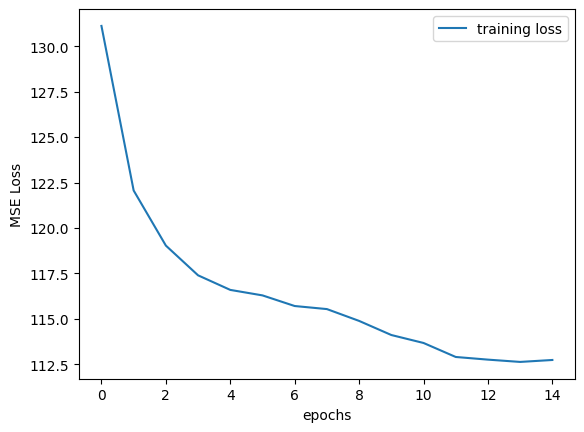

In [12]:
plt.plot(losses, label="training loss")
plt.xlabel("epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


### Make predictions and compute MSE

In [14]:
orig_df_test = pd.read_csv(test_file)
df_test_std = np.mean(orig_df_test, axis=1)
df_test_std = np.std(orig_df_test, axis=1)

/home/coco/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/coco/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3571: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [15]:
from sklearn.metrics import mean_squared_error

# Make predictions
with torch.no_grad():
    y_test_pred = model(df_test_tensor)

y_test_pred_inv_transformed = scaler.inverse_transform(y_test_pred)
print(y_test_pred_inv_transformed)
print(test_ids.shape, y_test_pred.shape, df_test_tensor.shape, type(y_test_pred))
out = np.column_stack([test_ids, y_test_pred_inv_transformed])
out = pd.DataFrame(out, columns=["id", "bg+1:00"])

out.to_csv("submission.csv", index=False)

[[8.29630367]
 [8.27704492]
 [8.27704492]
 ...
 [8.27704492]
 [8.30033165]
 [8.27704492]]
(3644,) torch.Size([3644, 1]) torch.Size([3644, 433]) <class 'torch.Tensor'>


In [16]:
print(y_tensor)

tensor([[1.7097],
        [1.5095],
        [2.4106],
        ...,
        [0.8086],
        [0.7419],
        [0.6418]])
